<a href="https://colab.research.google.com/github/ajoshiusc/lesion-detector/blob/master/lesion-detector/src/sergul/Focus_MRI_ReNA_colab_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI - packages
Alhussain Almarhabi



In [1]:
# first let's install important packages
!pip install utilis nilearn nibabel

    100% |████████████████████████████████| 2.3MB 6.9MB/s 
    100% |████████████████████████████████| 4.2MB 8.1MB/s 
  Running setup.py bdist_wheel for utilis ... - done
  Stored in directory: /root/.cache/pip/wheels/36/ad/20/c28a4ec7f29505b910418f843a7d3a1ce1ef52787f7d7a8ca4
  Running setup.py bdist_wheel for nibabel ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/6d/50/60/a2fcafe72ababac5240b3df2ee903197bec24b74d75840153f
Successfully built utilis nibabel


In [2]:
!rm -rf MRI_ReNA
# clone my github repository
!git clone https://github.com/code-Eng/MRI_ReNA/

Cloning into 'MRI_ReNA'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 560 (delta 49), reused 195 (delta 27), pack-reused 336
Receiving objects: 100% (560/560), 769.48 MiB | 33.77 MiB/s, done.
Resolving deltas: 100% (98/98), done.
Checking out files: 100% (293/293), done.


In [0]:
'''# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')'''

#rena.py

In [3]:
%%writefile rena.py

"""Recursive nearest agglomeration (ReNA):
    fastclustering for approximation of structured signals
Author:
    Andres Hoyos idrobo, Gael Varoquaux, Jonas Kahn and  Bertrand Thirion
"""
import numpy as np
from sklearn.utils.validation import check_is_fitted
from sklearn.externals.joblib import Parallel, delayed, Memory
from sklearn.externals import six
from scipy.sparse import csgraph, coo_matrix, dia_matrix
from sklearn.base import BaseEstimator
from sklearn.utils import check_array


def _compute_weights(masker, data_matrix):
    """Measuring the Euclidean distance: computer the weights in the direction
    of each axis
    Note: Here we are assuming a square lattice (no diagonal connections)
    """
    # data_graph shape
    dims = len(masker.mask_img_.shape)
    data_graph = masker.inverse_transform(data_matrix).get_data()
    weights = []

    for axis in range(dims):
        weights.append(
            np.sum(np.diff(data_graph, axis=axis) ** 2, axis=-1).ravel())

    return np.hstack(weights)


def _compute_edges(data_graph, is_mask=False):
    """
    """
    dims = len(data_graph.shape)
    edges = []
    for axis in range(dims):
        vertices_axis = np.swapaxes(data_graph, 0, axis)

        if is_mask:
            edges.append(np.logical_and(
                vertices_axis[:-1].swapaxes(axis, 0).ravel(),
                vertices_axis[1:].swapaxes(axis, 0).ravel()))
        else:
            edges.append(np.vstack(
                [vertices_axis[:-1].swapaxes(axis, 0).ravel(),
                 vertices_axis[1:].swapaxes(axis, 0).ravel()]))
    edges = np.hstack(edges)
    return edges


def _create_ordered_edges(masker, data_matrix):
    """
    """
    mask = masker.mask_img_.get_data()
    shape = mask.shape
    n_features = np.prod(shape)

    vertices = np.arange(n_features).reshape(shape)
    weights = _compute_weights(masker, data_matrix)
    edges = _compute_edges(vertices, is_mask=False)
    edges_mask = _compute_edges(mask, is_mask=True)

    # Apply the mask
    weights = weights[edges_mask]
    edges = edges[:, edges_mask]

    # Reorder the indices of the graph
    max_index = edges.max()
    order = np.searchsorted(np.unique(edges.ravel()), np.arange(max_index + 1))
    edges = order[edges]

    return edges, weights, edges_mask


def weighted_connectivity_graph(masker, data_matrix):
    """ Creating weighted graph
    data and topology, encoded by a connectivity matrix
    """
    n_features = masker.mask_img_.get_data().sum()

    edges, weight, edges_mask = _create_ordered_edges(masker, data_matrix)
    connectivity = coo_matrix(
        (weight, edges), (n_features, n_features)).tocsr()

    # Making it symmetrical
    connectivity = (connectivity + connectivity.T) / 2

    return connectivity


def _nn_connectivity(connectivity, thr):
    """ Fast implementation of nearest neighbor connectivity
    connectivity: weighted connectivity matrix
    """
    n_features = connectivity.shape[0]

    connectivity_ = coo_matrix(
        (1. / connectivity.data, connectivity.nonzero()),
        (n_features, n_features)).tocsr()

    inv_max = dia_matrix((1. / connectivity_.max(axis=0).toarray()[0], 0),
                         shape=(n_features, n_features))

    connectivity_ = inv_max * connectivity_

    # Dealing with eccentricities
    edge_mask = connectivity_.data > 1 - thr

    j_idx = connectivity_.nonzero()[1][edge_mask]
    i_idx = connectivity_.nonzero()[0][edge_mask]

    weight = np.ones_like(j_idx)
    edges = np.array((i_idx, j_idx))

    nn_connectivity = coo_matrix((weight, edges), (n_features, n_features))

    return nn_connectivity


def reduce_data_and_connectivity(labels, n_labels, connectivity, data_matrix,
                                 thr):
    """
    """
    n_features = len(labels)

    incidence = coo_matrix(
        (np.ones(n_features), (labels, np.arange(n_features))),
        shape=(n_labels, n_features), dtype=np.float32).tocsc()

    inv_sum_col = dia_matrix(
        (np.array(1. / incidence.sum(axis=1)).squeeze(), 0),
        shape=(n_labels, n_labels))

    incidence = inv_sum_col * incidence

    # reduced data
    reduced_data_matrix = (incidence * data_matrix.T).T
    reduced_connectivity = (incidence * connectivity) * incidence.T

    reduced_connectivity = reduced_connectivity - dia_matrix(
        (reduced_connectivity.diagonal(), 0), shape=(reduced_connectivity.shape))

    i_idx, j_idx = reduced_connectivity.nonzero()

    data_matrix_ = np.maximum(thr, np.sum(
        (reduced_data_matrix[:, i_idx] - reduced_data_matrix[:, j_idx]) ** 2, 0))
    reduced_connectivity.data = data_matrix_

    return reduced_connectivity, reduced_data_matrix


def nearest_neighbor_grouping(connectivity, data_matrix, n_clusters, thr):
    """ Cluster according to nn and reduce the data and connectivity
    """
    # Nearest neighbor conenctivity
    nn_connectivity = _nn_connectivity(connectivity, thr)

    n_features = connectivity.shape[0]

    n_labels = n_features - (nn_connectivity + nn_connectivity.T).nnz / 2

    if n_labels < n_clusters:
        # cut some links to achieve the desired number of clusters
        alpha = n_features - n_clusters

        nn_connectivity = nn_connectivity + nn_connectivity.T

        edges_ = np.array(nn_connectivity.nonzero())

        plop = edges_[0] - edges_[1]

        select = np.argsort(plop)[:alpha]

        nn_connectivity = coo_matrix(
            (np.ones(2 * alpha),
             np.hstack((edges_[:, select], edges_[::-1, select]))),
            (n_features, n_features))

    # Clustering step: getting the connected components of the nn matrix
    n_labels, labels = csgraph.connected_components(nn_connectivity)

    # Reduction step: reduction by averaging
    reduced_connectivity, reduced_data_matrix = reduce_data_and_connectivity(
        labels, n_labels, connectivity, data_matrix, thr)

    return reduced_connectivity, reduced_data_matrix, labels


def recursive_nearest_agglomeration(masker, data_matrix, n_clusters, n_iter,
                                    thr):
    """
    """
    # Weighted connectivity matrix
    connectivity = weighted_connectivity_graph(masker, data_matrix)

    # Initialization
    labels = np.arange(connectivity.shape[0])
    n_labels = connectivity.shape[0]

    for i in range(n_iter):
        connectivity, data_matrix, reduced_labels = nearest_neighbor_grouping(
            connectivity, data_matrix, n_clusters, thr)

        labels = reduced_labels[labels]
        n_labels = connectivity.shape[0]

        if n_labels <= n_clusters:
            break

    return n_labels, labels



class ReNA(BaseEstimator):
    """
    ReNA is useful.
    Parameters
    ----------
    masker: dd
    n_cluster: int, optional (default 2)
        Number of clusters.
    connectivity
    scaling: bool, optional (default False)
    memory: instance of joblib.Memory or string
        Used to cache the masking process.
        By default, no caching is done. If a string is given, it is the
        path to the caching directory.
    n_iter: int, optional (default 10)
        Number of iterations of the recursive nearest agglomeration
    n_jobs: int, optional (default 1)
        Number of jobs in solving the sub-problems.
    thr: float in the opened interval (0., 1.), optional (default 1e-7)
        Threshold used to deal with eccentricities.
    Attributes
    ----------
    `labels_`: numpy array
    `n_clusters_`: int
        Number of clusters
    `sizes_`: numpy array
        It contains the size of each cluster
    """
    def __init__(self, n_clusters=2, connectivity=None, masker=None, memory=None,
                 scaling=False, n_iter=10, thr=1e-7, n_jobs=1):
        self.n_clusters = n_clusters
        self.connectivity = connectivity
        self.memory = memory
        self.scaling = scaling
        self.n_iter = n_iter
        self.n_jobs = n_jobs
        self.masker = masker
        self.thr = thr

    def fit(self, X):
        """Compute clustering of the data
        Parameters
        ----------
        X : 2D array
        """

        X = check_array(X, ensure_min_features=2)

        memory = self.memory
        if isinstance(memory, six.string_types):
            memory = Memory(cachedir=memory, verbose=0)

        if self.n_clusters <= 0:
            raise ValueError("n_clusters should be an integer greater than 0."
                             " %s was provided." % str(self.n_clusters))

        n_labels, labels = recursive_nearest_agglomeration(
            self.masker, X, self.n_clusters, n_iter=self.n_iter, thr=self.thr)

        sizes = np.bincount(labels)
        sizes = sizes[sizes > 0]

        self.labels_ = labels
        self.n_clusters_ = np.unique(self.labels_).shape[0]
        self.sizes_ = sizes
        self.n_features = X.shape[1]
        
        return self


    def transform(self, X):
        """Apply clustering, reduce the dimensionality of the data
        Parameters
        ----------
        X: 2D array
        """
        N = X.shape[0]
        check_is_fitted(self, 'labels_')
        #unique_labels = np.unique(self.labels_)

#         nX = []
#         for l in unique_labels:
#             nX.append(np.mean(X[:, self.labels_ == l], axis=1))
#         Xred =  np.array(nX).T
        Xred = np.array([np.bincount(self.labels_, X[i,:])/self.sizes_ for i in range(N)])

        if self.scaling:
            Xred = Xred * np.sqrt(self.sizes_)

        return Xred
    
#     def generate_phi(self)
#         phi_T = cluster.transform( np.eye(self.n_features))
#         phi = phi_T.T # do sparse
#         self.phi = phi
#         return self

    def fit_transform(self, X):
        """Fit to data, then perform the clustering (transformation)
        """
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Xred):
        """
        """
        check_is_fitted(self, 'labels_')

        _, inverse = np.unique(self.labels_, return_inverse=True)

        if self.scaling:
            Xred = Xred / np.sqrt(self.sizes_)
        return Xred[..., inverse]

Writing rena.py


In [0]:
!git clone https://github.com/code-Eng/MRI_ReNA/

In [0]:
# used to delete old files in colab
#!ls
#!rm -rf sample_data
!ls

In [0]:
import glob
import nilearn as nl
import os
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d


def read_data(study_dir, nsub, psize, npatch_perslice):
    """
    study_dir      : is the study directory where each subjects have different
                    type of MRI stored.
    nsub           : is indicating the number of subject we have in
                    the study file
    psize          : is the patch size
    npatch_perslice: is number of patches per scan slice
    """
    dirlist = glob.glob(study_dir + '/TBI*')
    subno = 0
    patch_data = np.zeros((0, 0, 0, 0))
    for subj in dirlist:

        t1file = os.path.join(subj, 'T1.nii.gz')
        t2file = os.path.join(subj, 'T2.nii.gz')
        fl = os.path.join(subj, 'FLAIR.nii.gz')
        # check if three MRI contrast exist if not skip subject
        if not (os.path.isfile(t1file) and os.path.isfile(t2file)
                and os.path.isfile(fl)):
            print("one file missing (T1,T2 or FLAIR), go to the next subject")
            subno += 1
            continue

        if subno < nsub:
            subno = subno + 1
            print("subject %d " % (subno))
        else:
            break
        # Read the three images
        t1 = nl.image.load_img(t1file).get_data()
        t2 = nl.image.load_img(t2file).get_data()
        flair = nl.image.load_img(fl).get_data()

        p = np.percentile(np.ravel(t1), 95)  #normalize to 95 percentile
        t1 = np.float32(t1) / p

        p = np.percentile(np.ravel(t2), 95)  #normalize to 95 percentile
        t2 = np.float32(t2) / p

        p = np.percentile(np.ravel(flair), 95)  #normalize to 95 percentile
        flair = np.float32(flair) / p

        imgs = np.stack((t1, t2, flair), axis=3)

        for sliceno in range(imgs.shape[2]):
            ptch = extract_patches_2d(
                image=imgs[:, :, sliceno, :],
                patch_size=psize,
                max_patches=npatch_perslice)
            if patch_data.shape[0] == 0:
                patch_data = ptch
            else:
                patch_data = np.concatenate((patch_data, ptch), axis=0)

        # Read coronal slices

        #        create image

        #        create random patches

    return patch_data # npatch x width x height x channels


def get_single_subject(file_name):

    t1file = os.path.join(file_name, 'T1.nii.gz')
    t2file = os.path.join(file_name, 'T2.nii.gz')
    fl = os.path.join(file_name, 'FLAIR.nii.gz')

    t1 = nifti_masker.transform(image.load_img(t1file))
    t2 = nifti_masker.transform(image.load_img(t2file))
    flair = nifti_masker.transform(image.load_img(fl))

    p = np.percentile(np.ravel(t1), 95)  # normalize to 95 percentile
    t1 = np.float32(t1) / p

    p = np.percentile(np.ravel(t2), 95)  # normalize to 95 percentile
    t2 = np.float32(t2) / p

    p = np.percentile(np.ravel(flair), 95)  # normalize to 95 percentile
    flair = np.float32(flair) / p

    imgs = np.concatenate((t1, t2, flair))

    return imgs


In [0]:
# read all data in patches 


data_dir = 'MRI_ReNA/study_dir'

# Read data
data = read_data(study_dir=data_dir,
                 nsub=5,
                 psize=[128,128],
                 npatch_perslice=32)



In [0]:
data.shape

In [0]:
import nibabel as nib
imgg = nib.load('MRI_ReNA/study_dir/TBI_INVAX364NTZ/T1.nii.gz')
type(imgg)
print(imgg.header.get_data_shape())


In [0]:
from nilearn import plotting
plotting.plot_stat_map(stat_map_img='MRI_ReNA/study_dir/TBI_INVAX364NTZ/T1.nii.gz',
                       cut_coords=(-30, -65, -10),
                       threshold=10e-7, 
                       title="dim=-.5",
                       dim=-.5,
                       black_bg='True')

# ReNA 
### reference - [GitHub](https://github.com/ahoyosid/ReNA/blob/master/Example_Neuroimaging.ipynb)



1.   Loading Data
2.   Get the connectivity (spatial structure)
3.   Visualizing the result 






#MSE MRI Adding New subject

## Plot MSE for each images per subjects

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


one file missing (T1,T2 or FLAIR), go to the next subject

one file missing (T1,T2 or FLAIR), go to the next subject



/usr/local/lib/python3.6/dist-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.6/dist-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as False. Converting to None (no smoothing option)
  .format(fwhm))
/usr/local/lib/python3.6/dist-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.6/dist-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as False. Converting to None (no smoothing option)
  .format(fwhm))
/usr/local/lib/python3.6/dist-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.6/dist-packa

all images concatenate shape is  (36, 270806) 

 no. of voxels:  270806 
 no. of samples:  36 
 no. of clusters:  54161 




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide


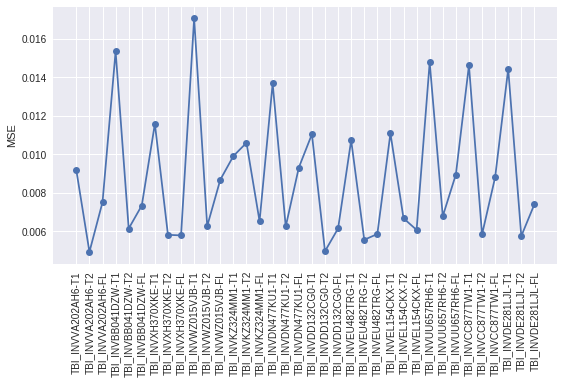

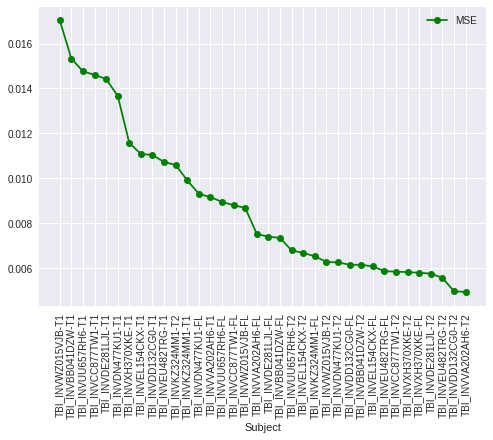

In [4]:
import nilearn 
from nilearn import image
from nilearn.input_data import NiftiMasker
import nibabel as nb
import os
import numpy as np
import rena
import matplotlib.pyplot as plt
import glob
import pandas as pd

# Befor run edit the dir_name to the path of your subject; include / at the end
dir_name = "MRI_ReNA/study_dir/"
f_len = len(dir_name.split('/'))
f_len = f_len-2

'''mask_img = nb.load('MRI_ReNA/study_dir/TBI_INVAX364NTZ/T1.nii.gz')
nifti_masker = NiftiMasker(mask_img=mask_img, smoothing_fwhm=False,
                           standardize=False)
nifti_masker.fit()'''

'''# using subject TBI_INVDD132CG0 FLAIR as masker for all data
nifti_masker = NiftiMasker( smoothing_fwhm=False,
                           standardize=False)
nifti_masker.fit('MRI_ReNA/supporting_data/grey10_icbm_2mm_bin.nii.gz')'''


mask_img = nb.load('MRI_ReNA/supporting_data/grey10_icbm_2mm_bin.nii.gz')
nifti_masker = NiftiMasker(mask_img=mask_img, smoothing_fwhm=False,
                           standardize=False)
nifti_masker.fit()

def subject_checker(study_folder):
    
    subject_list = glob.glob(study_folder + 'TBI*')
    target_subject = []

    for subject in subject_list:
      
      t1file = os.path.join(subject,'T1.nii.gz')
      t2file = os.path.join(subject,'T2.nii.gz')
      fl = os.path.join(subject,'FLAIR.nii.gz')

      if not (os.path.isfile(t1file) and os.path.isfile(t2file) 
              and os.path.isfile(fl)):
          print("one file missing (T1,T2 or FLAIR), go to the next subject\n")
          continue 
      else:
        target_subject.append(subject)
    
    return target_subject
      
def get_single_subject(file_name):
  
    t1file = os.path.join(file_name, 'T1.nii.gz')
    t2file = os.path.join(file_name, 'T2.nii.gz')
    fl = os.path.join(file_name, 'FLAIR.nii.gz')

    t1 = nifti_masker.transform(image.load_img(t1file))
    t2 = nifti_masker.transform(image.load_img(t2file))
    flair = nifti_masker.transform(image.load_img(fl))

    p = np.percentile(np.ravel(t1), 95)  # normalize to 95 percentile
    t1 = np.float32(t1) / p

    p = np.percentile(np.ravel(t2), 95)  # normalize to 95 percentile
    t2 = np.float32(t2) / p

    p = np.percentile(np.ravel(flair), 95)  # normalize to 95 percentile
    flair = np.float32(flair) / p

    imgs = np.concatenate((t1, t2, flair))

    return imgs
  

all_imgs = None

# checker include only the subject with T1,T2 and FLAIR MRI data
subject_list = subject_checker(dir_name)
#print(subject_list) # just to chekc we have the right subject 

for subject_name in subject_list:
    
    file_name = subject_name
    imgs = get_single_subject(file_name)
    
    if all_imgs is None:
        all_imgs = imgs
    else:
        all_imgs = np.concatenate((all_imgs, imgs))

      
print('all images concatenate shape is ',all_imgs.shape,'\n')

n_voxels = all_imgs.shape[1]
n_samples = all_imgs.shape[0]
n_clusters = int(20*n_voxels/100)
cluster = rena.ReNA(scaling=True,
               n_clusters=n_clusters,
               masker=nifti_masker)

print(' no. of voxels: ',n_voxels,'\n',
      'no. of samples: ',n_samples,'\n',
      'no. of clusters: ',n_clusters,'\n\n')

cluster.fit(all_imgs)

reduced_images = cluster.transform(all_imgs)
reconstructed_images = cluster.inverse_transform(reduced_images)

mse = np.mean(abs(all_imgs - reconstructed_images)**2, axis=1)
a_relative_chg = np.array(abs(all_imgs - reconstructed_images)/abs(all_imgs))
se = np.array(abs(all_imgs - reconstructed_images)**2)

labels_plot = []
for labels_p in subject_list:
    c_list = glob.glob(labels_p + '/*')
    # if there are other type nii.gz not wanted included as shown with 'fse.nii.gz'
    # ../../sample_data/TBI*/*  >>> 0/1/2/3/4
    # use f_len here
    for c in c_list:
      if c.split('/')[f_len+2] == 'T1.nii.gz':
        labels_plot.append(c.split('/')[f_len+1] + '-' + c.split('/')[f_len+2][0:2])
    for c in c_list:
      if c.split('/')[f_len+2] == 'T2.nii.gz':
        labels_plot.append(c.split('/')[f_len+1] + '-' + c.split('/')[f_len+2][0:2])
    for c in c_list:
      if c.split('/')[f_len+2] == 'FLAIR.nii.gz':
        labels_plot.append(c.split('/')[f_len+1] + '-' + c.split('/')[f_len+2][0:2])


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mse, marker='o')
ax.set_xticks(range(n_samples))
ax.set_xticklabels(labels_plot, rotation=90)
ax.set_ylabel("MSE")
plt.tight_layout()

df1 = pd.Series(labels_plot)
df2 = pd.Series(mse)
df = pd.DataFrame(df1,columns=['Subject'])
df['MSE'] = df2
df = df.sort_values(by='MSE',ascending=False)
dfplot = df.plot(x='Subject', y='MSE',marker='o',color='g')
dfplot.set_xticks(range(n_samples))
dfplot.set_xticklabels(df['Subject'],rotation=90)



plt.show()


In [5]:
df.head()

,Subject,MSE
9,TBI_INVWZ015VJB-T1,0.017045
3,TBI_INVBB041DZW-T1,0.015332
27,TBI_INVUU657RH6-T1,0.014764
30,TBI_INVCC877TW1-T1,0.014608
33,TBI_INVDE281LJL-T1,0.014423


## Average MSE for three images per subject (required to run previous code) 

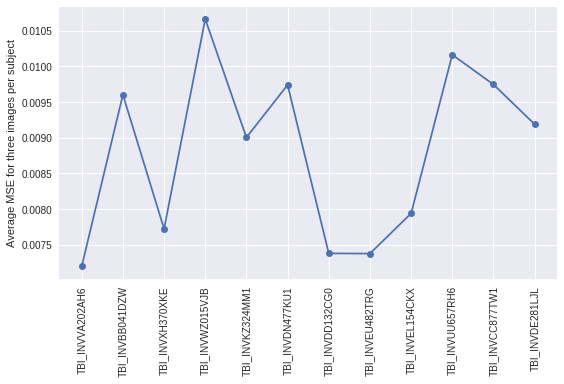

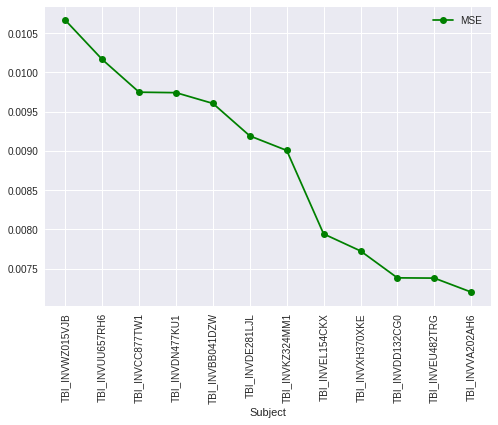

In [6]:
labels_plot2 = []
for labels_p in subject_list:
    labels_plot2.append(labels_p.split('/')[f_len+1])

#labels_plot2 = np.array(labels_plot2)
mse1 = np.array([(sum(mse[i:i+3]))/3 for i in range(0,len(mse),3)])
nn_samples = int(n_samples/3)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mse1, marker='o')
ax.set_xticks(range(nn_samples))
ax.set_xticklabels(labels_plot2, rotation=90)
ax.set_ylabel("Average MSE for three images per subject")
plt.tight_layout()

df1 = pd.Series(labels_plot2)
df2 = pd.Series(mse1)
df = pd.DataFrame(df1,columns=['Subject'])
df['MSE'] = df2
df = df.sort_values(by='MSE',ascending=False)
dfplot2 = df.plot(x='Subject', y='MSE',marker='o',color='g')
dfplot2.set_xticks(range(nn_samples))
dfplot2.set_xticklabels(df['Subject'],rotation=90)


plt.show()

## ReNA on one subject then can plot needed images (do not run)

In [0]:
import nilearn 
from nilearn import image
from nilearn.input_data import NiftiMasker
import nibabel as nb
import os
import numpy as np
import rena
import matplotlib.pyplot as plt
import glob

# Befor run edit the dir_name to the path of your subject; include / at the end
dir_name = "MRI_ReNA/study_dir/"
f_len = len(dir_name.split('/'))
f_len = f_len-2



mask_img = nb.load('MRI_ReNA/supporting_data/grey10_icbm_2mm_bin.nii.gz')
nifti_masker = NiftiMasker(mask_img=mask_img, smoothing_fwhm=False,
                           standardize=False)
nifti_masker.fit()

def subject_checker(study_folder):
    
    subject_list = glob.glob(study_folder + 'TBI*')
    target_subject = []

    for subject in subject_list:
      
      t1file = os.path.join(subject,'T1.nii.gz')
      t2file = os.path.join(subject,'T2.nii.gz')
      fl = os.path.join(subject,'FLAIR.nii.gz')

      if not (os.path.isfile(t1file) and os.path.isfile(t2file) 
              and os.path.isfile(fl)):
          print("one file missing (T1,T2 or FLAIR), go to the next subject\n")
          continue 
      else:
        target_subject.append(subject)
    
    return target_subject
      
def get_single_subject(file_name):
  
    t1file = os.path.join(file_name, 'T1.nii.gz')
    t2file = os.path.join(file_name, 'T2.nii.gz')
    fl = os.path.join(file_name, 'FLAIR.nii.gz')

    t1 = nifti_masker.transform(image.load_img(t1file))
    t2 = nifti_masker.transform(image.load_img(t2file))
    flair = nifti_masker.transform(image.load_img(fl))

    p = np.percentile(np.ravel(t1), 95)  # normalize to 95 percentile
    t1 = np.float32(t1) / p

    p = np.percentile(np.ravel(t2), 95)  # normalize to 95 percentile
    t2 = np.float32(t2) / p

    p = np.percentile(np.ravel(flair), 95)  # normalize to 95 percentile
    flair = np.float32(flair) / p

    imgs = np.concatenate((t1, t2, flair))

    return imgs
  

all_imgs = None

# checker include only the subject with T1,T2 and FLAIR MRI data
subject_list = ['MRI_ReNA/study_dir/TBI_INVWZ015VJB/'] #subject_checker(dir_name)

for subject_name in subject_list:
    
    file_name = subject_name
    imgs = get_single_subject(file_name)
    
    if all_imgs is None:
        all_imgs = imgs
    else:
        all_imgs = np.concatenate((all_imgs, imgs))

      
print('all images concatenate shape is ',all_imgs.shape,'\n')

n_voxels = all_imgs.shape[1]
n_samples = all_imgs.shape[0]
n_clusters = int(20*n_voxels/100)
cluster = rena.ReNA(scaling=True,
               n_clusters=n_clusters,
               masker=nifti_masker)

print(' no. of voxels: ',n_voxels,'\n',
      'no. of samples: ',n_samples,'\n',
      'no. of clusters: ',n_clusters,'\n\n')

cluster.fit(all_imgs)

reduced_images = cluster.transform(all_imgs)
reconstructed_images = cluster.inverse_transform(reduced_images)

# apply abs(reconstructed-original)/abs(original) 

relative_chg = np.array(abs(reconstructed_images - all_imgs)/abs(all_imgs))

from nilearn import plotting



## Plotting MRI images after running ReNA (require previous code)

To find idex for specific subject use the following:
`labels_plot.index('TBI_INVEU482TRG-FL')`
the name you use in the method must be similar as the generated one in MSE chart

In [7]:
labels_plot.index('TBI_INVEU482TRG-FL')

23

In [8]:
print(reconstructed_images.shape)
print(mse.shape)
print(a_relative_chg.shape)
print(se.shape)


(36, 270806)
(36,)
(36, 270806)
(36, 270806)


/usr/local/lib/python3.6/dist-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_e

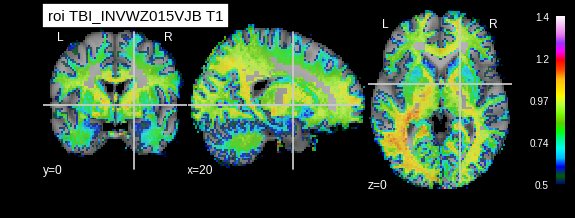

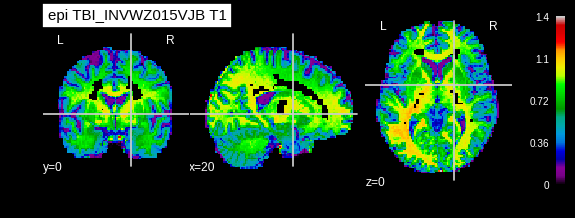

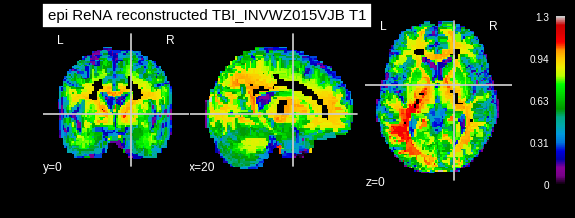

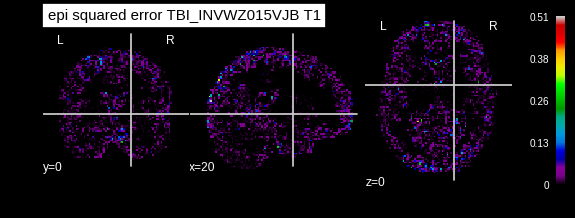

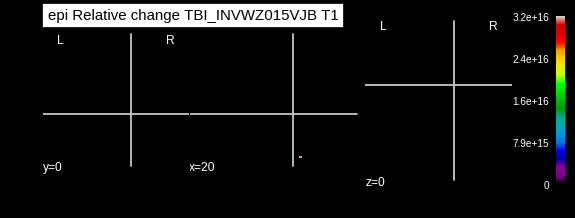

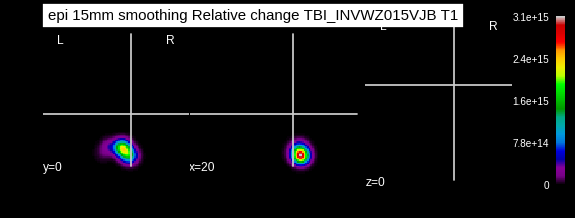

In [9]:
from nilearn import plotting, image
# subjeact TBI_INVWZ015VJB [21 T1] 
# labels_plot.index('TBI_INVWZ015VJB-T1') = 21
 
plotting.plot_roi(nifti_masker.inverse_transform(all_imgs[21]), title="roi TBI_INVWZ015VJB T1",
                  cut_coords=(20, 0,0),black_bg='True',colorbar=True)

plotting.plot_epi(nifti_masker.inverse_transform(all_imgs[21]), title="epi TBI_INVWZ015VJB T1",
                  cut_coords=(20, 0,0),black_bg='True',colorbar=True)
plotting.plot_epi(nifti_masker.inverse_transform(reconstructed_images[21]), title="epi ReNA reconstructed TBI_INVWZ015VJB T1",
                  cut_coords=(20, 0,0),black_bg='True',colorbar=True)

plotting.plot_epi(nifti_masker.inverse_transform(se[21]), title="epi squared error TBI_INVWZ015VJB T1",
                  cut_coords=(20, 0,0),black_bg='True',colorbar=True)

plotting.plot_epi(nifti_masker.inverse_transform(a_relative_chg[21]), title="epi Relative change TBI_INVWZ015VJB T1",
                  cut_coords=(20, 0,0),black_bg='True',colorbar=True)
                  
#Smooth the relative changes
mean_func = image.mean_img(nifti_masker.inverse_transform((a_relative_chg[21])))

# Then we smooth, with a varying amount of smoothing, from none to 20mm
# by increments of 5mm

smoothed_img = image.smooth_img(mean_func, 15)
plotting.plot_epi(smoothed_img, title="epi 15mm smoothing Relative change TBI_INVWZ015VJB T1",
                  cut_coords=(20, 0,0),black_bg='True',colorbar=True)